In [575]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [576]:
pd.options.mode.chained_assignment = None

In [577]:
data = pd.read_csv('data\\Houses.csv', encoding='latin-1')

In [578]:
krakow_data = data[data.city == 'Kraków']
krakow_sm_data = krakow_data[krakow_data.address.str.contains('Stare Miasto')]
full_dataset = krakow_sm_data[['price', 'sq']]
full_dataset = full_dataset.reset_index()

współczynnik korelacji pearsona

This function also performs a test of the null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [579]:
stats.pearsonr(full_dataset.sq, full_dataset.price)

PearsonRResult(statistic=0.8147345405614029, pvalue=3.2877077440199363e-161)

silna dodatnia korelacja

## Zadanie 4. Prosta regresji liniowej

In [580]:
size = full_dataset.shape[0]
test_size = int(size * 0.1)
test_dataset = full_dataset.loc[size-test_size:, :]
dataset = full_dataset.loc[:size-test_size - 1, :]

In [581]:
def linear_regression(x, y):
    b1 = sum((x - np.mean(x)) * y) / sum((x - np.mean(x)) ** 2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return b0, b1

### Bez logarytmów

In [582]:
a1, b1 = linear_regression(dataset.sq, dataset.price)

In [583]:
r = 1 - np.sum((dataset.price - (a1 + b1 * dataset.sq)) ** 2) / np.sum((dataset.price - np.mean(dataset.price)) ** 2)
print(r)

0.674008281082313


In [584]:
a, b = linear_regression(dataset.sq, dataset.price)

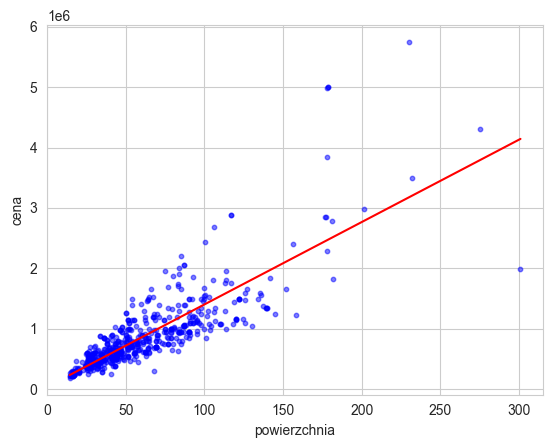

In [585]:
plt.scatter(dataset.sq,dataset.price, c='blue', alpha=0.5, s=10)
t = np.array([np.min(dataset.sq), np.max(dataset.sq)])
plt.plot(t, a + b * t, c='red')
plt.xlabel('powierzchnia')
_ = plt.ylabel('cena')

### Z logarytmami

In [586]:
dataset['log_sq'] = np.log(dataset.sq)
dataset['log_price'] = np.log(dataset.price)

In [587]:
a_log, b_log = linear_regression(dataset.log_sq, dataset.log_price)

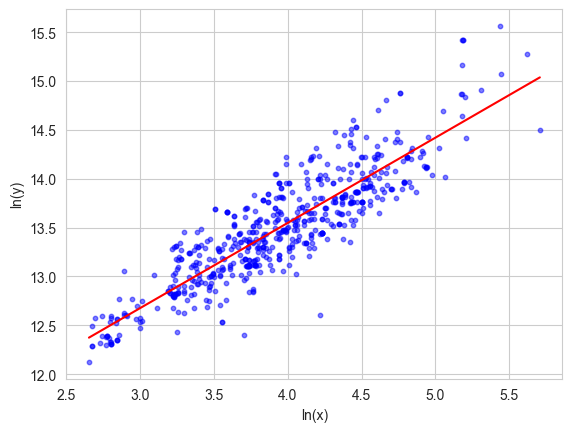

In [588]:
plt.scatter(dataset.log_sq,dataset.log_price, c='blue', alpha=0.5, s=10)
t = np.array([np.min(dataset.log_sq), np.max(dataset.log_sq)])
plt.plot(t, a_log + b_log * t, c='red')
plt.xlabel('ln(x)')
_ = plt.ylabel('ln(y)')

### Zadanie 5. Przedziały ufności

In [589]:
def S(b0_est, b1_est, x, y): # estymator wariancji
    m = len(x)
    return np.sqrt(np.sum((y - b0_est - b1_est * x)**2) / (m - 2))

In [590]:
n = len(dataset.sq)
alpha = 0.05

### Bez logarytmów

In [591]:
s = S(a, b, dataset.sq, dataset.price)

przedział ufności dla b1

In [592]:
dummy_b1 = stats.t.ppf(1 - alpha/2, n-2) * s / np.sqrt(np.sum((dataset.sq - np.mean(dataset.sq))**2))

In [593]:
b - dummy_b1, b + dummy_b1

(12882.179890430463, 14396.929869970438)

przedział ufności dla b0

In [594]:
dummy_b0 = stats.t.ppf(1-alpha/2, n-2) * s * np.sqrt(1/n + np.mean(dataset.sq)**2/np.sum((dataset.sq - np.mean(dataset.sq))**2))

In [595]:
a - dummy_b0, a + dummy_b0

(-15410.121145084748, 91854.04298417341)

### Z logarytmami

In [596]:
s_log = S(a_log, b_log, dataset.log_sq, dataset.log_price)

dla b1_log

In [597]:
dummy_b1_log = stats.t.ppf(1 - alpha / 2, n - 2) * s_log / np.sqrt(np.sum((dataset.log_sq - np.mean(dataset.log_sq)) ** 2))
b_log - dummy_b1_log, b_log + dummy_b1_log

(0.834774506072182, 0.9096005351872231)

dla b0_log

In [598]:
dummy_b0_log = stats.t.ppf(1 - alpha / 2, n - 2) * s_log * np.sqrt(1 / n + np.mean(dataset.log_sq) ** 2 / np.sum((dataset.log_sq - np.mean(dataset.log_sq)) ** 2))
a_log - dummy_b0_log, a_log + dummy_b0_log

(9.911515453558547, 10.209092248833624)

## Zadanie 6. Analiza residuów

### Bez logarytmów

In [599]:
dataset['price_est'] = a + b * dataset.sq  # estymatory Y
dataset['e'] = dataset.price - dataset.price_est  # residua

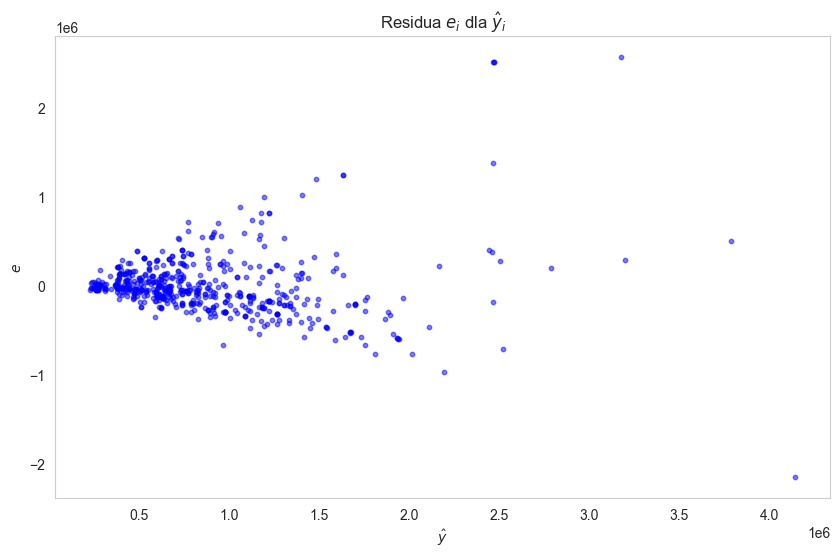

In [600]:
fig = plt.figure(figsize=(10,6))
plt.title('Residua $e_i$ dla $\hat{y}_i$')
plt.ylabel('$e$')
plt.xlabel('$\hat{y}$')
plt.scatter(dataset.price_est, dataset.e, c='blue', s=10, alpha=0.5)
plt.grid()
plt.savefig('pictures\\residual_vs_fitted.pdf')

In [601]:
np.mean(dataset.e) # Średnia blisko 0

-6.29064671486567e-11

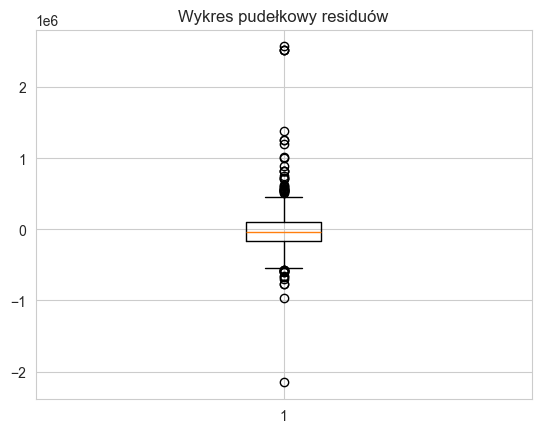

In [602]:
plt.boxplot(dataset.e)
_ = plt.title('Wykres pudełkowy residuów')

In [603]:
print(stats.kstest((dataset.e - np.mean(dataset.e))/np.std(dataset.e), 'norm')) # nie mają rozkładu normalnego
print(stats.jarque_bera((dataset.e - np.mean(dataset.e))/np.std(dataset.e)))

KstestResult(statistic=0.1399924105305259, pvalue=7.690368151574256e-11, statistic_location=0.40978760867942615, statistic_sign=1)
SignificanceResult(statistic=10151.064088967409, pvalue=0.0)


In [604]:
import seaborn as sns

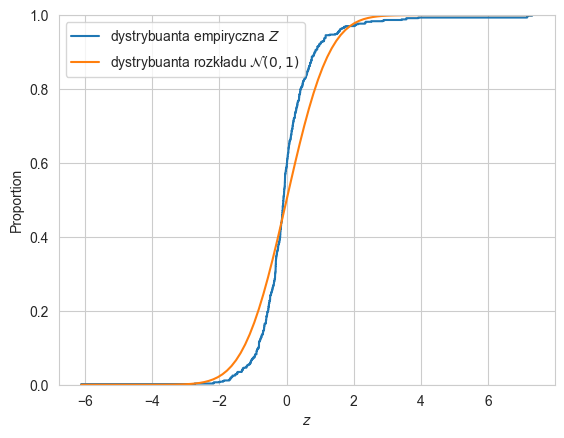

In [605]:
sns.ecdfplot((dataset.e - np.mean(dataset.e))/np.std(dataset.e))
t = np.linspace(np.min((dataset.e - np.mean(dataset.e))/np.std(dataset.e)), np.max((dataset.e - np.mean(dataset.e))/np.std(dataset.e)), 100)
plt.plot(t, stats.norm.cdf(t))
plt.legend(['dystrybuanta empiryczna $Z$', 'dystrybuanta rozkładu $\mathcal{N}{(0, 1)}$'])
plt.xlabel('$z$')
plt.savefig('pictures\\dystrybuanty.pdf')

Nie ma rozkładu normalnego.

### Z logarytmami

Często w przypadku heteroskedaktyczności jest logarytmowana zmienna objaśniana, żeby zmniejszyć lub zlikwidować efekt.

In [606]:
dataset['price_est_log'] = a_log + b_log * dataset.log_sq # estymatory Y
dataset['e_log'] = dataset.log_price - dataset.price_est_log  # residua

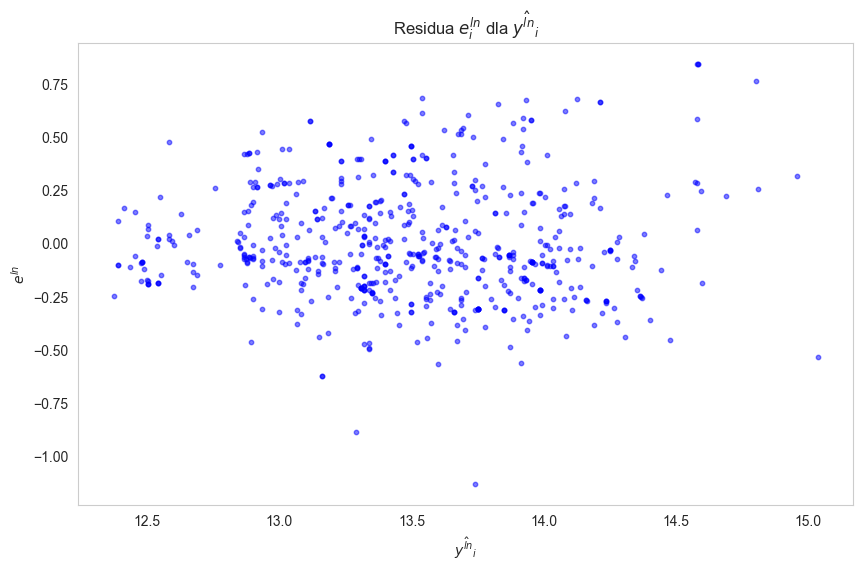

In [607]:
fig2 = plt.figure(figsize=(10,6))
plt.title('Residua $e^{ln}_i$ dla $\hat{y^{ln}}_i$')
plt.ylabel('$e^{ln}$')
plt.xlabel('$\hat{y^{ln}}_i$')
plt.scatter(dataset.price_est_log, dataset.e_log, c='blue', s=10, alpha=0.5)
plt.grid()
plt.savefig('pictures\\residual_vs_fitted_logarytmowane.pdf')

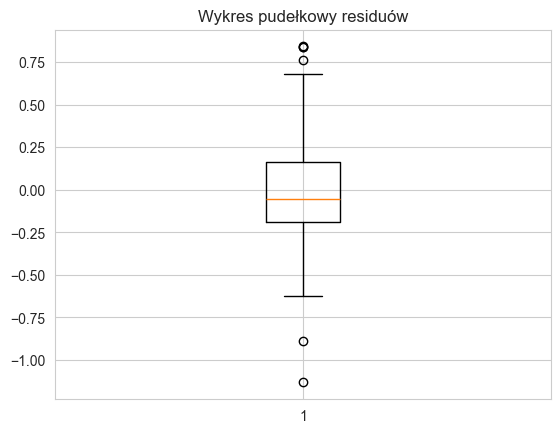

In [608]:
plt.boxplot(dataset.e_log)
_ = plt.title('Wykres pudełkowy residuów') # znacznie mniej, niż w poprzednim przypadku

In [609]:
np.mean(dataset.e_log)

-4.887176147938086e-16

In [610]:
np.var(dataset.e_log)

0.07164004947925166

In [611]:
stats.kstest((dataset.e_log - np.mean(dataset.e_log))/np.std(dataset.e_log), 'norm')

KstestResult(statistic=0.09165319171959962, pvalue=6.899675815475094e-05, statistic_location=-0.18327164051520595, statistic_sign=1)

In [612]:
stats.jarque_bera((dataset.e_log - np.mean(dataset.e_log))/np.std(dataset.e_log))

SignificanceResult(statistic=23.87307376554467, pvalue=6.546782287933797e-06)

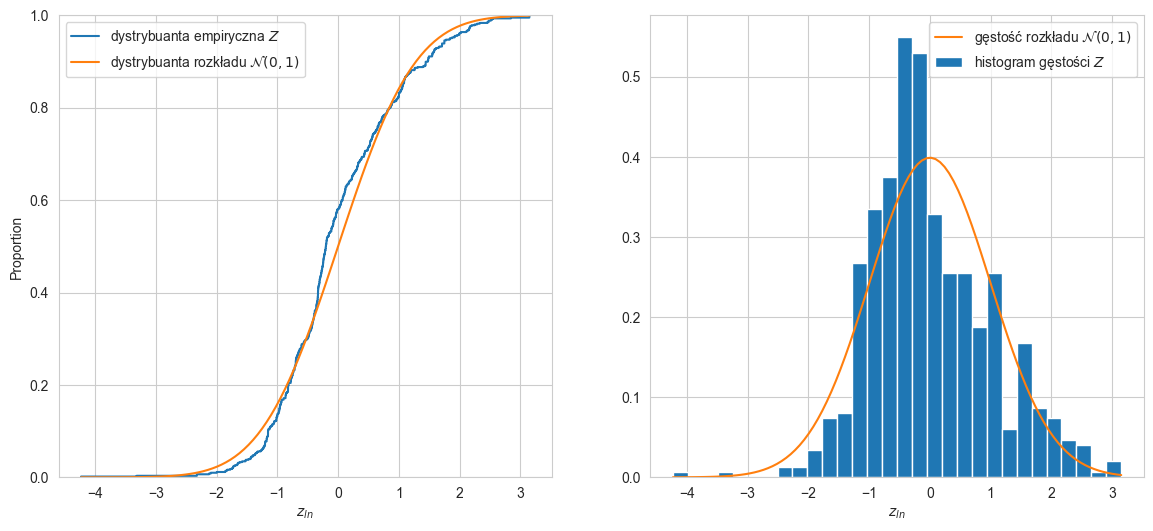

In [613]:
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Horizontally stacked subplots')
e_log_normalized = (dataset.e_log - np.mean(dataset.e_log))/np.std(dataset.e_log)
sns.ecdfplot(e_log_normalized, ax=ax1)
t = np.linspace(np.min(e_log_normalized), np.max(e_log_normalized), 100)
ax1.plot(t, stats.norm.cdf(t))
ax1.legend(['dystrybuanta empiryczna $Z$', 'dystrybuanta rozkładu $\mathcal{N}{(0, 1)}$'])
ax1.set_xlabel('$z_{ln}$')
ax2.hist(e_log_normalized, density=True, bins=30)
ax2.plot(t, stats.norm.pdf(t))
ax2.set_xlabel('$z_{ln}$')
ax2.legend(['gęstość rozkładu $\mathcal{N}{(0, 1)}$', 'histogram gęstości $Z$'])
plt.savefig('pictures\\distribution.pdf')

## Zadanie 7. Prognoza przyszłej wartości $Y{(x_0)}$

In [614]:
def confidence_interval(Y_est, s, x0, x, alpha=0.05):
    m = len(x)
    dummy1 = 1 + 1/m + (x0 - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)
    dummy2 = stats.t.ppf(1-alpha/2, m-2) * s * np.sqrt(dummy1)
    return Y_est - dummy2, Y_est + dummy2

In [615]:
# def get_confidence_interval_unknown(x0, x, b0, b1, s, alpha=0.05):
#     n = len(x)
#     a = stats.t.ppf(1-alpha/2, n-2) * s * np.sqrt(1 + 1/n + (x0 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
#     y_est = b0_est + b1_est*x0
#     return y_est - a, y_est + a

### Część 1 - bez logarytmów

In [616]:
test_dataset = test_dataset.sort_values(by='sq', ascending=True)

In [617]:
s = S(a, b, dataset.sq, dataset.price)
confidence_intervals = np.array([confidence_interval(a + b * new_surface, s, new_surface, dataset.sq, alpha=0.05) for new_surface in test_dataset.sq])

In [618]:
counter = 0
for interval, new_price in zip(confidence_intervals, test_dataset.price):
    if interval[0] <= new_price <= interval[1]:
        counter += 1

In [619]:
print(confidence_intervals[0, 0] - confidence_intervals[0, 1])

-1389798.7895295415


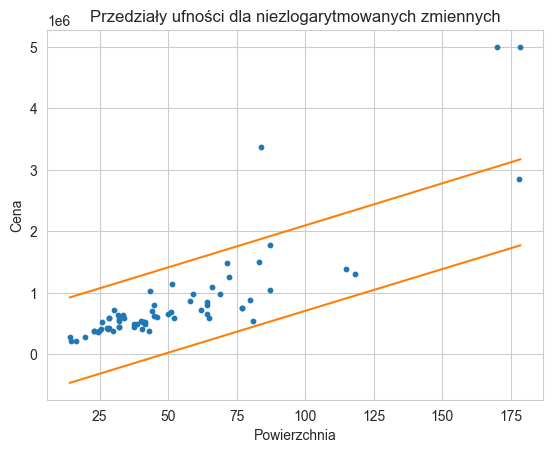

In [620]:
plt.plot(test_dataset.sq, confidence_intervals[:, 0], c='C1')
plt.plot(test_dataset.sq, confidence_intervals[:, 1], c='C1')
plt.title('Przedziały ufności dla niezlogarytmowanych zmiennych')
plt.ylabel('Cena')
plt.xlabel('Powierzchnia')
_ = plt.scatter(test_dataset.sq, test_dataset.price, s=10, c='C0')
plt.savefig('pictures\\proznoza.pdf')

In [621]:
counter/test_size # procent wpadających wartości

0.9552238805970149

### Część 2 - z logarytmami

In [622]:
test_dataset['log_price'] = np.log(test_dataset.price)
test_dataset['log_sq'] = np.log(test_dataset.sq)

In [623]:
s_log = S(a_log, b_log, dataset.log_sq, dataset.log_price)

In [624]:
confidence_intervals_log = np.array([confidence_interval(a_log + b_log * new_surface, s_log, new_surface, dataset.log_sq, alpha=0.05) for new_surface in test_dataset.log_sq])

In [625]:
counter = 0
for interval, new_price in zip(confidence_intervals_log, test_dataset.log_price):
    if interval[0] <= new_price <= interval[1]:
        counter += 1

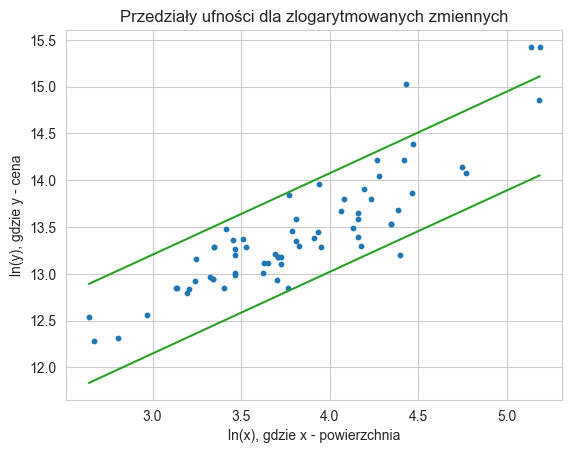

In [626]:
plt.plot(test_dataset.log_sq, confidence_intervals_log[:, 0], c='C2')
plt.plot(test_dataset.log_sq, confidence_intervals_log[:, 1], c='C2')
plt.title('Przedziały ufności dla zlogarytmowanych zmiennych')
plt.xlabel('ln(x), gdzie x - powierzchnia')
plt.ylabel('ln(y), gdzie y - cena')
_ = plt.scatter(test_dataset.log_sq, test_dataset.log_price, c='C0', s=10)
plt.savefig('pictures\\prognoza_logarytmy.pdf')

In [627]:
print(np.mean(np.exp(confidence_intervals_log[:, 1]) - np.exp(confidence_intervals_log[:, 0])))

818280.1408034966


In [628]:
counter/test_size # procent wpadających wartości

0.9402985074626866

### Na jednym wykresie

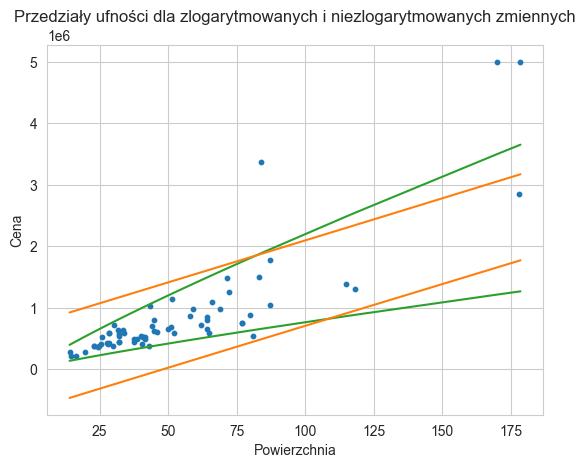

In [631]:
line2, = plt.plot(test_dataset.sq, np.exp(confidence_intervals_log[:, 0]), c='C2', label='dla zlogarytmowanych')
plt.plot(test_dataset.sq, np.exp(confidence_intervals_log[:, 1]), c='C2')

line1, = plt.plot(test_dataset.sq, confidence_intervals[:, 0], c='C1', label='dla niezlogarytmowanych')
plt.plot(test_dataset.sq, confidence_intervals[:, 1], c='C1')

plt.title('Przedziały ufności dla zlogarytmowanych i niezlogarytmowanych zmiennych')
plt.xlabel('Powierzchnia')
plt.ylabel('Cena')
plt.scatter(test_dataset.sq, test_dataset.price, c='C0', s=10)
plt.savefig('pictures\\prognoza_razem.pdf')